[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100]


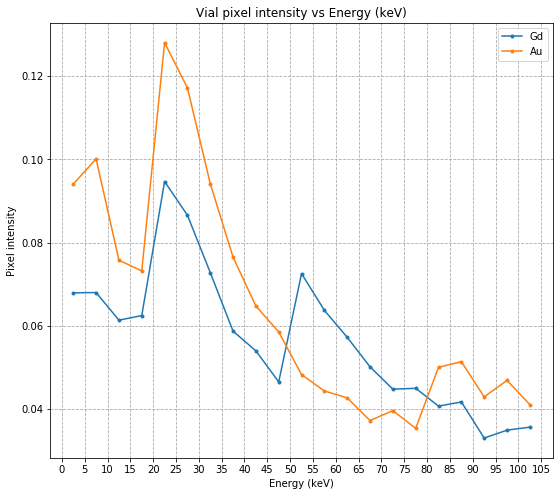

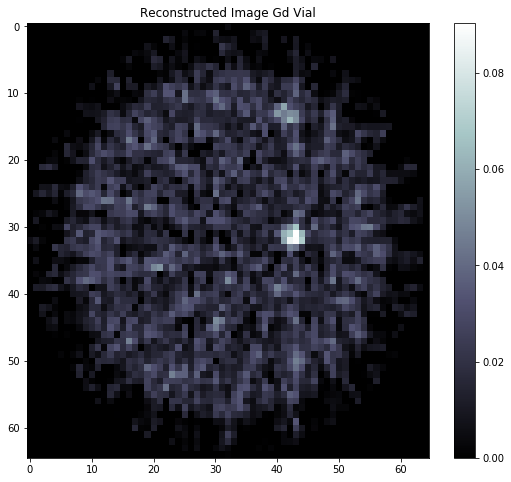

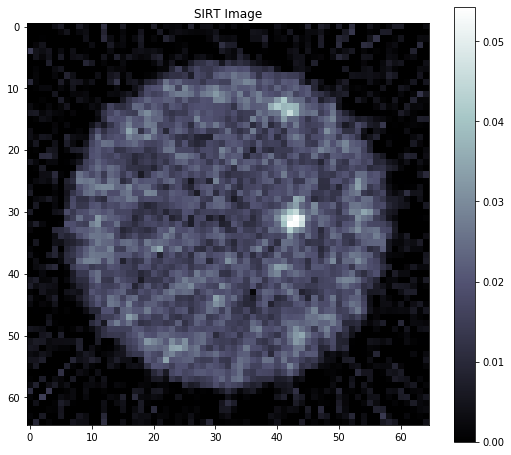

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
from matplotlib.pyplot import figure
from skimage.transform import iradon
import astra

bin_width=5
bins=np.arange(0,105,bin_width)
#airscans
airscan_counts = [sum(genfromtxt("Desktop/CT imaging/17-5-2021/Air scan.mca", skip_header=int(round(i*550/81+12)),max_rows=int(round(bin_width*550/81)))) for i in bins] 

master_counts=[]
tot_counts=[]
avg_counts=[]
for k in np.arange(0,len(bins)):
    for i in np.arange(0,360,20):
        for j in np.arange(1,66):
            counts = genfromtxt("Desktop/CT imaging/17-5-2021/angle_{:d}_acq_{:02d}.mca".format(i,j), skip_header=int(round(bins[k]*550/81+12)),max_rows=int(round(bin_width*550/81)))
            avg_counts.append(-np.log(sum(counts)/airscan_counts[k]))
            counts=0
        tot_counts.append(avg_counts)
        avg_counts=[]
    master_counts.append(tot_counts)
    tot_counts=[]
    

master_counts=np.array(master_counts)
master_counts=[np.transpose(x) for x in master_counts]
'''#image reconstruction 
theta=np.arange(0,360,20)
for i in np.arange(0,len(bins)):
    image1=iradon(master_counts[i],theta=theta)
    image1[image1<0] = 0
    figure(i+1,figsize=(9,8))
    plt.imshow(image1,aspect='auto',cmap='bone')
    plt.colorbar()
    plt.title('Reconstructed Image')'''

#vial pixel coords
coords1=np.array([[21, 32] ,[21., 32.], [22., 32.] ,[22., 33.], [23., 33.], [23., 33.]])

coords2=np.array([[42. ,31.] ,[42., 31.] ,[43. ,31.] ,[43., 32.] ,[44., 32.] ,[44. ,32.]])

#image data
theta=np.arange(0,360,20)
images=[]
for i in np.arange(0,len(bins)):
    images.append(iradon(master_counts[i],theta=theta))
    images[i][images[i]<0]=0

#vial 1 (left)
mask1=np.zeros(shape=(65,65))
for x,y in coords1:
    mask1[int(y)][int(x)]=1
vial1=mask1*images
vial1[vial1==0]=np.nan
vial1_mean=[np.nanmean(i) for i in vial1]

#vial 2 (right)
mask2=np.zeros(shape=(65,65))
for x,y in coords2:
    mask2[int(y)][int(x)]=1
vial2=mask2*images
vial2[vial2==0]=np.nan
vial2_mean=[np.nanmean(i) for i in vial2]

#intensity of vials vs energy
figure(1,figsize=(9,8))
plt.plot(bins+bin_width/2,vial1_mean,marker='.',label='Gd')
plt.plot(bins+bin_width/2,vial2_mean,marker='.',label='Au')
plt.title('Vial pixel intensity vs Energy (keV)')
plt.grid(linestyle='--',c='darkgray')
plt.xlabel('Energy (keV)')
plt.ylabel('Pixel intensity') 
plt.locator_params(axis="x", nbins=30)
plt.legend()

print(bins)
subtraction=master_counts[4]-master_counts[10]

#image reconstruction Gd
theta=np.arange(0,360,20)
image1=iradon(subtraction,theta=theta)
image1[image1<0] = 0
figure(2,figsize=(9,8))
plt.imshow(image1,aspect='auto',cmap='bone')
plt.colorbar()
plt.title('Reconstructed Image Gd Vial')

#image reconstruction Au
# theta=np.arange(0,360,20)
# image1=iradon(master_counts[4]-master_counts[6],theta=theta)
# image1[image1<0] = 0
# figure(70,figsize=(9,8))
# plt.imshow(image1,aspect='auto',cmap='bone')
# plt.colorbar()
# plt.title('Reconstructed Image Au Vial')


#create geometries and projector
proj_geom = astra.create_proj_geom('parallel', 1,65, np.arange(0,2*np.pi,np.pi/9));
vol_geom = astra.create_vol_geom(65,65);
sinogram = astra.data2d.create('-sino',proj_geom,np.transpose(subtraction));
recon_id = astra.data2d.create('-vol', vol_geom,data=iradon(subtraction,theta=theta))
proj_id= astra.create_projector('line',proj_geom,vol_geom)

# Set up the parameters for a reconstruction algorithm using the CPU
# The main difference with the configuration of a GPU algorithm is the
# extra ProjectorId setting.
cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = recon_id
cfg['ProjectionDataId'] = sinogram
cfg['ProjectorId']=proj_id
# Available algorithms:
# ART, SART, SIRT, CGLS, FBP


# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run x iterations of the algorithm
# This will have a runtime in the order of 10 seconds.
astra.algorithm.run(alg_id, 50)

# Get the result
rec3 = astra.data2d.get(recon_id)
rec3[rec3<0] = 0
figure(8,figsize=(9,8))
plt.imshow(rec3,cmap='bone')
plt.colorbar()
plt.title('SIRT Image')


# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(recon_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)
